## Moisture Vapor Cyclone Model Training
In this notebook, we take the data that was downloaded from the GOES-16 satellite and associated with the IBTRaCS storm database as shown in the following gif:

<img src="aux/img/output.gif" width="800">

We now attempt to train a CNN on it using the paper "Tropical and Extratropical Cyclone Detection Using Deep Learning" (Kumler-Bonfanti et al). The paper uses a U-net architecture developed in "U-Net: Convolutional Networks for Biomedical Image Segmentation" (Ronneberger et al). The network architecture is shown below:

<img src="aux/img/unet_arch.png" width="800">

## Pre-processing Data
First, we need to pre-process our training data. Our raw input image size is `1500x1200px` with a healthy amount of white space around the actual area of interest. To account for this, we'll crop to a square image approximately around the full-disk extent then downsize to a more reasonable input image shape of `512x512px`. Additionally we'll do some background subtraction to isolate the mask. This will all be saved into a separate folder for training in keras/tf. Let's do this by defining some functions and work with a singular image for demonstration.

In [179]:
# input pillow package (import as PIL for backwards compatibility per https://stackoverflow.com/a/23834693)
from PIL import Image, ImageOps
import PIL
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers
import pathlib
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import datetime as dt
import io

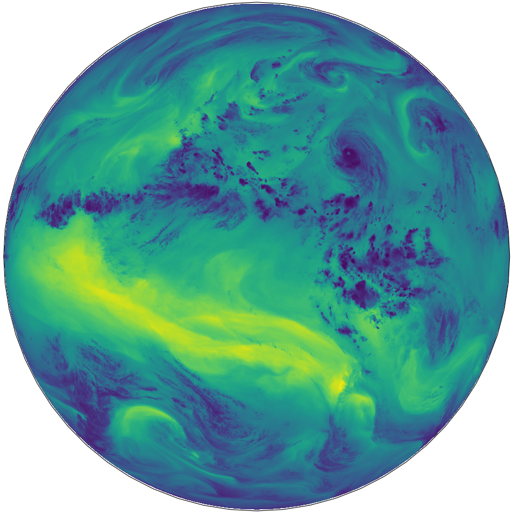

In [148]:
# define function to load/crop/resize GOES image data
def resize_crop_goes(fp, crop_dims = (300, 140, 1235, 1070), resize_dims = (512, 512)):
    # crop dims are empirically defined
    pic = Image.open(fp)
    return pic.crop(crop_dims).resize(resize_dims)
    
fp = 'data/dataset/raw/2017-09-22-00-00-00_raw.png'
resize_crop_goes(fp)

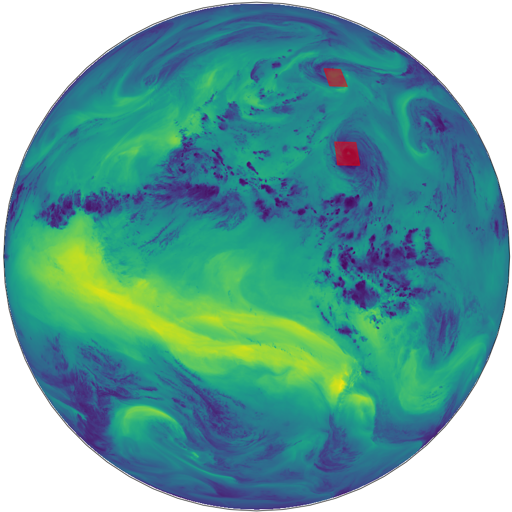

In [149]:
# next, lets look at the analog labeled image
# note that you can't really see the mask due to the grayscale but the computer can :)
fp_labeled = 'data/dataset/labeled/2017-09-22-00-00-00_labeled.png'
resize_crop_goes(fp_labeled)

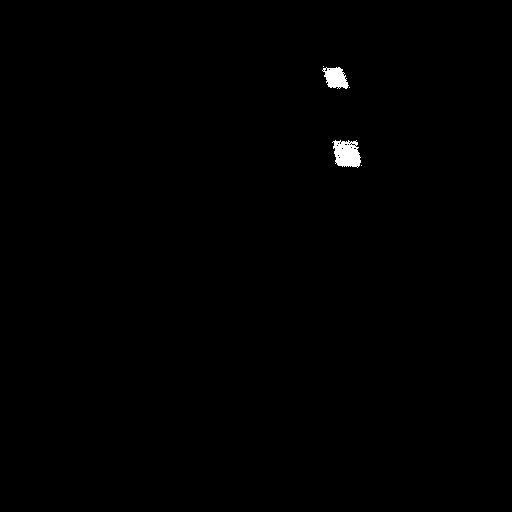

In [150]:
# finally, we can use background subtraction between the two images
def gen_mask(img1, img2):
    npimg1 = np.array(ImageOps.grayscale(img1))
    npimg2 = np.array(ImageOps.grayscale(img2))
    mask = np.abs(npimg1-npimg2)
    mask = np.where(mask>0, 1, 0).astype(np.bool_) # PIL needs dtype to infer, store as bool to play nice with labels in tf
    return Image.fromarray(mask)

masked_img = gen_mask(resize_crop_goes(fp), resize_crop_goes(fp_labeled))
masked_img

In [151]:
# now that we have our two functions, lets write into our `keras_dataset` folder with the baseline images and the truth images
# do some path stuff
read_path_raw = "data/dataset/raw"
write_path_raw =  "data/dataset/keras_dataset/raw"
read_path_labeled = "data/dataset/labeled"
write_path_mask = "data/dataset/keras_dataset/labels"
curr_dir = os.getcwd()

raw_files = os.listdir(os.path.join(curr_dir, read_path_raw))
labeled_files = os.listdir(os.path.join(curr_dir, read_path_labeled))

# get data pairs (raw/labeled) and do some image processing to convert to grayscale and get a binary mask as truth value
for data_pair in tqdm(list(zip(sorted(raw_files), sorted(labeled_files)))):
    img0 = resize_crop_goes(os.path.join(curr_dir, read_path_raw, data_pair[0]))  # raw image
    img1 = resize_crop_goes(os.path.join(curr_dir, read_path_labeled, data_pair[1]))  # labeled image
    img0.save(os.path.join(curr_dir, write_path_raw, data_pair[0]))
    mask = gen_mask(img0, img1)
    mask.save(os.path.join(os.getcwd(), write_path_mask, data_pair[1]))

100%|██████████| 1460/1460 [04:53<00:00,  4.97it/s]


## Assembling a dataset and training a model
Now that we have pre-processed data (`512x512px` grayscale raw images with binary mask truth output), we can assembly a keras dataset and train the model. This section is heavily adapted from a similar Keras tutorial (https://keras.io/examples/vision/oxford_pets_image_segmentation/). 

In [152]:
# define some global stuff (pretty lazily, I define image size in two places)
img_size = (512, 512)
num_classes = 2
batch_size = 50

# get paths to assemble training/truth data
input_img_paths = [os.path.join(write_path_raw, fname) for fname in sorted(raw_files)]
target_img_paths = [os.path.join(write_path_mask, fname) for fname in sorted(labeled_files)]
print("Number of samples:", len(input_img_paths))
for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 1460
data/dataset/keras_dataset/raw/2017-02-28-12-00-00_raw.png | data/dataset/keras_dataset/labels/2017-02-28-12-00-00_labeled.png
data/dataset/keras_dataset/raw/2017-03-01-00-00-00_raw.png | data/dataset/keras_dataset/labels/2017-03-01-00-00-00_labeled.png
data/dataset/keras_dataset/raw/2017-03-01-12-00-00_raw.png | data/dataset/keras_dataset/labels/2017-03-01-12-00-00_labeled.png
data/dataset/keras_dataset/raw/2017-03-02-00-00-00_raw.png | data/dataset/keras_dataset/labels/2017-03-02-00-00-00_labeled.png
data/dataset/keras_dataset/raw/2017-03-02-12-00-00_raw.png | data/dataset/keras_dataset/labels/2017-03-02-12-00-00_labeled.png
data/dataset/keras_dataset/raw/2017-03-03-00-00-00_raw.png | data/dataset/keras_dataset/labels/2017-03-03-00-00-00_labeled.png
data/dataset/keras_dataset/raw/2017-03-03-12-00-00_raw.png | data/dataset/keras_dataset/labels/2017-03-03-12-00-00_labeled.png
data/dataset/keras_dataset/raw/2017-03-04-00-00-00_raw.png | data/dataset/keras_dataset

In [153]:
# create a class that inherits from tf.keras.utils.Sequence (https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence)
# we can pass this directly into the model. Read the documentation for information on required methods

class GOES_Images(tf.keras.utils.Sequence):
    
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        
    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
    
    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = tf.keras.preprocessing.image.load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="bool_")
        for j, path in enumerate(batch_target_img_paths):
            img = tf.keras.preprocessing.image.load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        return x, y

In [154]:
# next define the U-net model
def get_model(img_size, num_classes):
    inputs = tf.keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = tf.keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
tf.keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
# model.summary()

## Training: Overfit
To verify that our model architecture is working, it is generally prudent to make sure that the model can overfit a small amount of data. We do this by training on a single image/truth pair to show that the network can learn properly. In practice this is not very useful but acts as a diagnostic tool.

In [85]:
# train dummy data to overfit model to debug
model = get_model(img_size, num_classes)
train_input_img_paths = ["data/dataset/raw/2017-09-28-12-00-00_raw.png" for i in range(1,100)]
train_target_img_paths = ["data/dataset/keras_dataset/labels/2017-09-28-12-00-00_labeled.png" for i in range(1,100)]
val_input_img_paths = ["data/dataset/raw/2017-09-28-12-00-00_raw.png" for i in range(1,20)]
val_target_img_paths = ["data/dataset/keras_dataset/labels/2017-09-28-12-00-00_labeled.png" for i in range(1,20)]
# Instantiate data Sequences for each split
train_gen = GOES_Images(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = GOES_Images(batch_size, img_size, val_input_img_paths, val_target_img_paths)
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("models/checkpoints/cyclone_segmentation_overfit.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 150  # original run was 1000 but looking at validation loss 150 is enough
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)
model.save("models/cyclone_classifier_overfit")

Epoch 1/1000
1/1 [==============================] - 38s 38s/step - loss: 2.0963
Epoch 2/1000
1/1 [==============================] - 29s 29s/step - loss: 1.0464
Epoch 3/1000
1/1 [==============================] - 28s 28s/step - loss: 1.1311
Epoch 4/1000
1/1 [==============================] - 28s 28s/step - loss: 0.1586
Epoch 5/1000
1/1 [==============================] - 28s 28s/step - loss: 0.1461
Epoch 6/1000
1/1 [==============================] - 30s 30s/step - loss: 0.1331
Epoch 7/1000
1/1 [==============================] - 30s 30s/step - loss: 0.1170
Epoch 8/1000
1/1 [==============================] - 32s 32s/step - loss: 0.0969
Epoch 9/1000
1/1 [==============================] - 33s 33s/step - loss: 0.0804
Epoch 10/1000
1/1 [==============================] - 34s 34s/step - loss: 0.0692
Epoch 11/1000
1/1 [==============================] - 35s 35s/step - loss: 0.0535
Epoch 12/1000
1/1 [==============================] - 33s 33s/step - loss: 0.0428
Epoch 13/1000
1/1 [==================

In [116]:
# Generate predictions for all images in the validation set
val_gen = GOES_Images(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_preds = model.predict(val_gen)

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(mask))
    return img

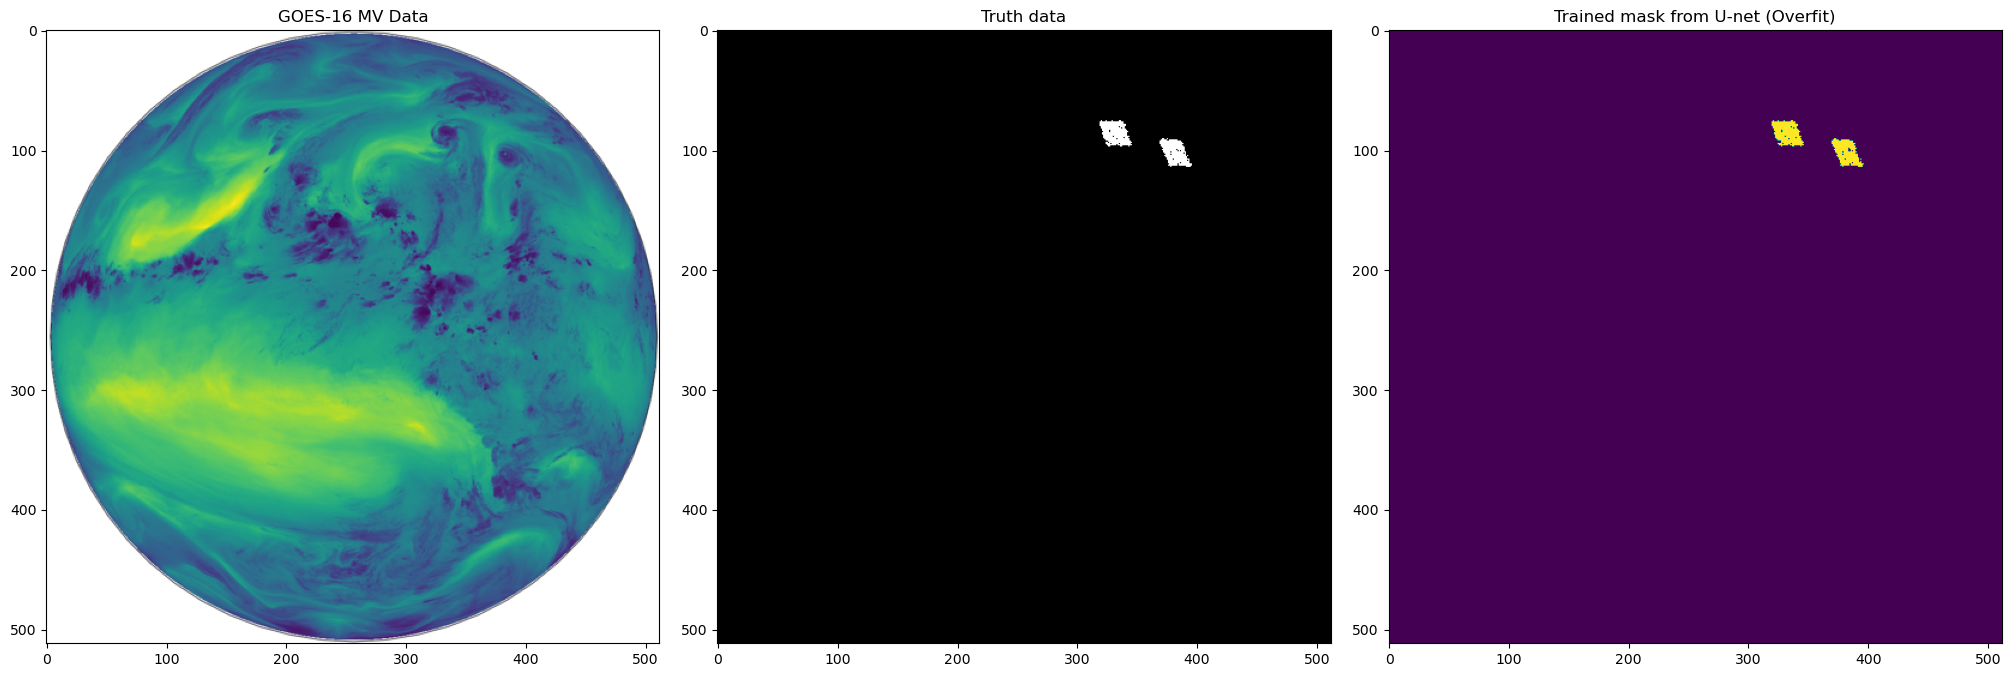

In [132]:
# Display results for validation image #10
i = 10

# load images
inimg = resize_crop_goes(val_input_img_paths[i], gray=False)
truthimg = Image.open(val_target_img_paths[i])
trainimg = display_mask(i)

# plot stuff
fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(20, 20))

axs[0].imshow(inimg)
axs[0].set_title('GOES-16 MV Data')

axs[1].imshow(truthimg)
axs[1].set_title('Truth data')

axs[2].imshow(trainimg)
axs[2].set_title('Trained mask from U-net (Overfit)')
plt.show()

## Training: Real Deal
Now that we've shown the model can overfit a simple example, lets train the model using real data.

In [155]:
# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = GOES_Images(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = GOES_Images(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [228]:
len(input_img_paths)

1460

In [156]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("models/checkpoints/cyclone_segmentation.h5", save_best_only=True),
]

# Train the model, doing validation at the end of each epoch.
epochs = 100
# history = 
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

# save model
model.save("models/cyclone_classifier_trained")

Epoch 1/100
9/9 [==============================] - 438s 51s/step - loss: 3.8346 - val_loss: 56.1610
Epoch 2/100
9/9 [==============================] - 657s 78s/step - loss: 0.0408 - val_loss: 0.2189
Epoch 3/100
9/9 [==============================] - 419s 49s/step - loss: 0.0261 - val_loss: 0.0170
Epoch 4/100
9/9 [==============================] - 439s 51s/step - loss: 0.0192 - val_loss: 0.0093
Epoch 5/100
9/9 [==============================] - 447s 52s/step - loss: 0.0090 - val_loss: 0.0072
Epoch 6/100
9/9 [==============================] - 471s 55s/step - loss: 0.0091 - val_loss: 0.0075
Epoch 7/100
9/9 [==============================] - 488s 57s/step - loss: 0.0075 - val_loss: 0.0078
Epoch 8/100
9/9 [==============================] - 479s 56s/step - loss: 0.0069 - val_loss: 0.0080
Epoch 9/100
9/9 [==============================] - 451s 53s/step - loss: 0.0066 - val_loss: 0.0081
Epoch 10/100
9/9 [==============================] - 497s 58s/step - loss: 0.0071 - val_loss: 0.0082
Epoch 11

In [220]:
# now that we've trained some weights, lets visualize the output
# lets look at the 2017 storm season including hurricane maria which is pretty interesting
# convert to date time, parse based on range criteria, sort
# bisect is the other option if you have a sorted list which os.listdir() does not return
start_date_str = dt.datetime.strptime("2017-09-01-12-00-00", "%Y-%m-%d-%H-%M-%S")
end_date_str = dt.datetime.strptime("2017-10-01-00-00-00", "%Y-%m-%d-%H-%M-%S")
vis_idx_list = []

input_dates = (dt.datetime.strptime(os.path.basename(date_string).split("_")[0], "%Y-%m-%d-%H-%M-%S") for date_string in val_input_img_paths)  # parenthesis in lieu of brackets for list comprehension  
date_range = filter(lambda x: start_date_str <= x <= end_date_str, input_dates)
string_dates = sorted(date.strftime("%Y-%m-%d-%H-%M-%S") for date in date_range)

maria_raw_fps = [os.path.join(write_path_raw, (fp+"_raw.png")) for fp in string_dates]  # this will give the binary mask
maria_overlayed_fps = [os.path.join(read_path_raw, (fp+"_raw.png")) for fp in string_dates]  # this will give overlayed mask
maria_labeled_fps = [os.path.join(write_path_mask, (fp+ "_labeled.png")) for fp in string_dates]

In [221]:
# load in the saved model weights and make predictions
trained_model = tf.keras.models.load_model('models/cyclone_classifier_trained')
trained_val_gen = GOES_Images(len(maria_raw_fps), img_size, maria_raw_fps, maria_labeled_fps)
trained_val_preds = trained_model.predict(trained_val_gen)

In [227]:
# visualize the output
images = []
for raw_fp, labeled_fp, pred_array in tqdm(zip(maria_overlayed_fps, maria_labeled_fps, trained_val_preds)):
    
    # load images
#     inimg = Image.open(raw_fp)
    inimg = resize_crop_goes(raw_fp)
    truthimg = Image.open(labeled_fp)
    mask = np.argmax(pred_array, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    trainimg = PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(mask))

    # plot stuff
    fig, axs = plt.subplots(1, 3, figsize=(20, 20))

    axs[0].imshow(inimg)
    axs[0].set_title('GOES-16 MV Data')

    axs[1].imshow(truthimg)
    axs[1].set_title('Truth data')

    axs[2].imshow(trainimg)
    axs[2].set_title('Trained mask from U-net')

    fig.suptitle('Hurrican Maria GOES Moisture Vapor Data + Predictions', fontsize=16, y=0.65)
#     plt.show()

    # save to a buffer rather than locally for performance
    # (per https://stackoverflow.com/a/61756899)
    buf = io.BytesIO()
    fig.savefig(buf, bbox_inches='tight')
    buf.seek(0)
    images.append(PIL.Image.open(buf))
    
    images[0].save('trained_comparison.gif',
                   save_all=True, append_images=images[1:], optimize=False, duration=200, loop=0)

20it [00:16,  1.15s/it]<ipython-input-227-ef4525d6ab4a>:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 3, figsize=(20, 20))
40it [00:40,  1.01s/it]
